# SBML interpolation
`sbmlutils` provides functionality for creating interpolated functions in SBML models. This allows to drive the model with experimental data sets. 

## Dataset
In a first step an experimental data set is loaded as a `pandas` DataFrame.

In [2]:
%matplotlib inline

     x    y      z
0  0.0  0.0  10.00
1  1.0  2.0   5.00
2  2.0  1.0   2.50
3  3.0  1.5   1.25
4  4.0  2.5   0.60
5  5.0  3.5   0.30


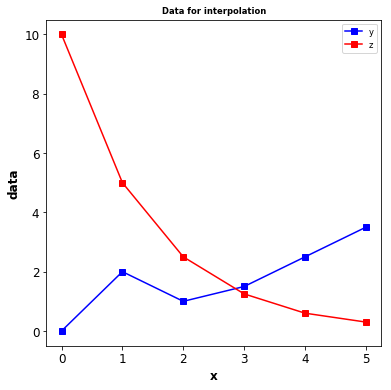

In [3]:
import pandas as pd
from matplotlib import pyplot as plt

# nicer plots
from sbmlutils.dfba.analysis import set_matplotlib_parameters
set_matplotlib_parameters()

# load dataset
data = pd.read_csv('./data/interpolation/data1.tsv', '\t')
print(data)

# plot data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.plot(data['x'], data['y'], '-s', label="y", color="blue")
ax.plot(data['x'], data['z'], '-s', label="z", color="red")
ax.set_title("Data for interpolation")
ax.set_xlabel('x')
ax.set_ylabel('data')

ax.legend()
plt.show()

## Interpolate data
Now we interpolate the experimental data with different methods and
write the resulting SBML models with the interpolation functions.

In [4]:
# import the interpolation functionality
from sbmlutils.interpolation import *
import os
if not os.path.exists('tmp'):
    os.mkdir('tmp')

# constant interpolation
ip_constant = Interpolation(data=data, method=INTERPOLATION_CONSTANT)
ip_constant.write_sbml_to_file("./tmp/data1_constant.xml")

# linear interpolation
ip_linear = Interpolation(data=data, method=INTERPOLATION_LINEAR)
ip_linear.write_sbml_to_file("./tmp/data1_linear.xml")

# natural cubic spline
ip_cubic = Interpolation(data=data, method=INTERPOLATION_CUBIC_SPLINE)
ip_cubic.write_sbml_to_file("./tmp/data1_cubic.xml")

## Simulate
In the next step we can use the interpolation SBML models for simulation.

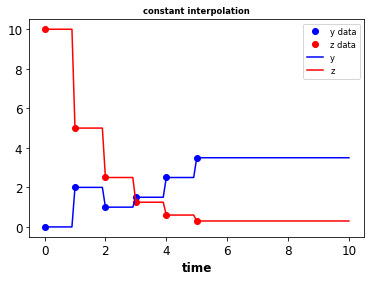

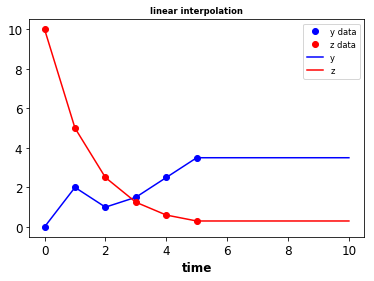

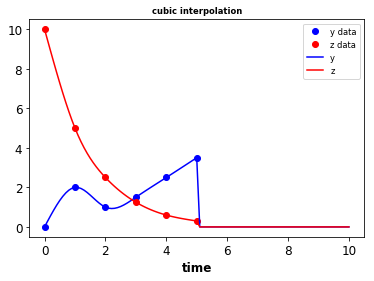

In [5]:
# simulate
def plot_data(s, name):
    """ Helper function for plotting interpolation with data. """
    from matplotlib import pyplot as plt
    plt.plot(data['x'], data['y'], 'o', label="y data", color="blue")
    plt.plot(data['x'], data['z'], 'o', label="z data", color="red")
    plt.plot(s['time'], s['y'], '-', label="y", color="blue")
    plt.plot(s['time'], s['z'], '-', label="z", color="red")
    plt.xlabel('time')
    plt.title('{} interpolation'.format(name))
    plt.legend()

import roadrunner
for name in ['constant', 'linear', 'cubic']:
    sbml_file = './tmp/data1_{}.xml'.format(name)
    r = roadrunner.RoadRunner(sbml_file)
    
    # Simulate the interpolation
    r.timeCourseSelections = ['time', 'y', 'z']
    s = r.simulate(0,10,steps=100)
    # print(s)

    plot_data(s, name=name)
    plt.show()

## Combine models
Combination of a fitted data model with a regular model via comp.
In the following example antimony is used to combine the splines with the model.

In [6]:
'''
import antimony
from sbmlutils.interpolation import Interpolation, INTERPOLATION_CUBIC_SPLINE

ip = Interpolation(data=data, method=INTERPOLATION_CUBIC_SPLINE)
sbml_str = ip.write_sbml_to_string()
r = te.loads(sbml_str)
a_spline = r.getAntimony()
print(a_spline)
'''

'\nimport antimony\nfrom sbmlutils.interpolation import Interpolation, INTERPOLATION_CUBIC_SPLINE\n\nip = Interpolation(data=data, method=INTERPOLATION_CUBIC_SPLINE)\nsbml_str = ip.write_sbml_to_string()\nr = te.loads(sbml_str)\na_spline = r.getAntimony()\nprint(a_spline)\n'

In [5]:
'''
# combine the models with antimony
a_test = a_spline + """
model *test()
    // add spline submodel to the model
    A: Interpolation_cubic_spline();
    
    J0: S1 -> S2; k1*S1;
    J1: $S3 -> S2; k1*S3;
    J2: $S4 -> S2; k1*S4;
    S1 = 10.0; S2=0.0; S3=0.0; S4=0.0
    k1 = 0.3;
    
    // use the submodel info in model not working
    A.y is y;
    A.z is z;
    
    S3 := y
    S4 := z
end
"""

r2 = te.loada(a_test)
print(r2.getAntimony())
r2.timeCourseSelections = ['time'] + r2.getBoundarySpeciesIds() + r2.getFloatingSpeciesIds()
print(r2.timeCourseSelections)

s = r2.simulate(0, 10, 101)
r2.plot(s)
'''

'\n# combine the models with antimony\na_test = a_spline + """\nmodel *test()\n    // add spline submodel to the model\n    A: Interpolation_cubic_spline();\n    \n    J0: S1 -> S2; k1*S1;\n    J1: $S3 -> S2; k1*S3;\n    J2: $S4 -> S2; k1*S4;\n    S1 = 10.0; S2=0.0; S3=0.0; S4=0.0\n    k1 = 0.3;\n    \n    // use the submodel info in model not working\n    A.y is y;\n    A.z is z;\n    \n    S3 := y\n    S4 := z\nend\n"""\n\nr2 = te.loada(a_test)\nprint(r2.getAntimony())\nr2.timeCourseSelections = [\'time\'] + r2.getBoundarySpeciesIds() + r2.getFloatingSpeciesIds()\nprint(r2.timeCourseSelections)\n\ns = r2.simulate(0, 10, 101)\nr2.plot(s)\n'